In [ ]:
import os
import wfdb
import pandas as pd
import numpy as np
from tqdm import tqdm


ecg_dir = r"D:\Projects\Cardiac Patient Monitoring System\Shaoxing and Ningbo Hospital ECG Database\WFDB_ShaoxingUniv"


NUM_SAMPLES = 5000


records = []


hea_files = [f for f in os.listdir(ecg_dir) if f.endswith('.hea')]


record_names = [os.path.splitext(f)[0] for f in hea_files]


for record_name in tqdm(record_names, desc="Reading ECG files"):
    record_path = os.path.join(ecg_dir, record_name)

    try:

        record = wfdb.rdrecord(record_path)

        if record.p_signal is not None and record.p_signal.shape[1] >= 1:
            signal = record.p_signal[:, 0]  
            signal = signal[:NUM_SAMPLES]     
            signal = np.pad(signal, (0, max(0, NUM_SAMPLES - len(signal))), 'constant', constant_values=0) 
                  
            records.append([record_name] + signal.tolist())
    except Exception as e:
        print(f" Error reading {record_name}: {e}")

#  DataFrame
columns = ["record_name"] + [f"ecg_{i}" for i in range(NUM_SAMPLES)]
df = pd.DataFrame(records, columns=columns)


df.to_csv(r"D:\Projects\Cardiac Patient Monitoring System\ecg_signals.csv", index=False)
print(" ECG data saved to ecg_signals.csv")

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load ECG signals (skip record_name column)
df = pd.read_csv(r"D:\Projects\Cardiac Patient Monitoring System\ecg_signals.csv")
X = df.drop(columns=["record_name"]).values

# Normalize data (بدون PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cluster with KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster info
df["cluster"] = clusters

# Map clusters to risk levels (manually after visual analysis)
risk_map = {
    0: "Stable",
    1: "Critical Risk",
    2: "Moderate Risk"
}
df["risk_level"] = df["cluster"].map(risk_map)

# Save final version
df.to_csv(r"D:\Projects\Cardiac Patient Monitoring System\ecg_signals_with_risk_labels.csv", index=False)

print("✅ Done: Data normalized, clustered, and labeled with risk_level")

D:\anaconda\envs\mimic_env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


✅ Done: Data normalized, clustered, and labeled with risk_level


In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
for n_clusters in range(2, 6):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, clusters)
    print(f"n_clusters={n_clusters}, silhouette_score={score:.3f}")

D:\anaconda\envs\mimic_env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


n_clusters=2, silhouette_score=0.657


D:\anaconda\envs\mimic_env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


n_clusters=3, silhouette_score=0.153


D:\anaconda\envs\mimic_env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


n_clusters=4, silhouette_score=0.171


D:\anaconda\envs\mimic_env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


n_clusters=5, silhouette_score=0.126


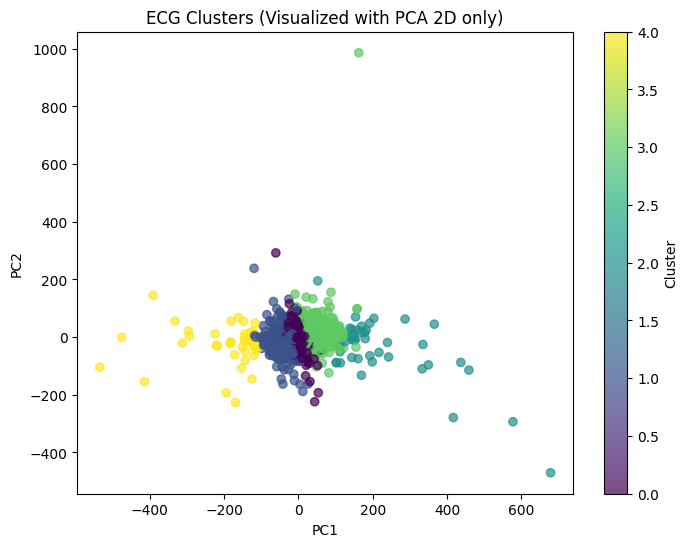

In [4]:
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=2)
X_vis = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.title("ECG Clusters (Visualized with PCA 2D only)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster')
plt.show()


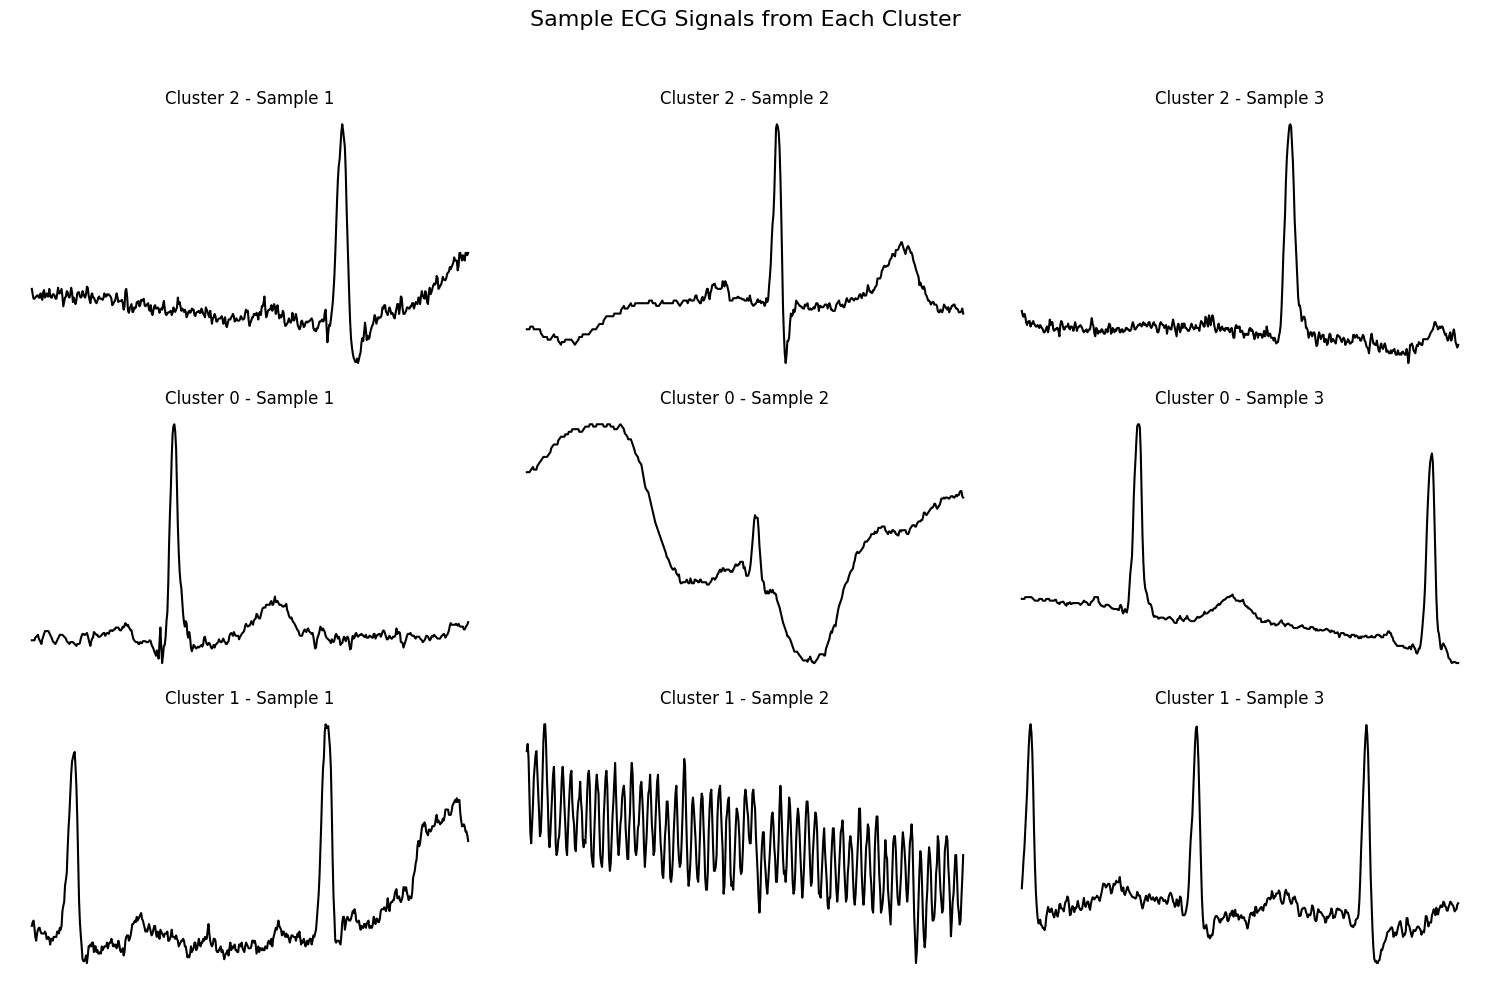

In [5]:
import matplotlib.pyplot as plt
import random

#  Cluster
NUM_SAMPLES_PER_CLUSTER = 3
NUM_POINTS_TO_PLOT = 500  

# "risk_level"
clusters = df["cluster"].unique()

plt.figure(figsize=(15, 10))
plot_index = 1

for cluster in clusters:
#      Cluster
    cluster_samples = df[df["cluster"] == cluster].sample(NUM_SAMPLES_PER_CLUSTER, random_state=42)

    for i in range(NUM_SAMPLES_PER_CLUSTER):
        signal = cluster_samples.iloc[i, 1:1+NUM_POINTS_TO_PLOT].values  

        plt.subplot(len(clusters), NUM_SAMPLES_PER_CLUSTER, plot_index)
        plt.plot(signal, color='black')
        plt.title(f"Cluster {cluster} - Sample {i+1}")
        plt.axis('off')  
        plot_index += 1

plt.suptitle("Sample ECG Signals from Each Cluster", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm
import warnings
import os
import pickle
import joblib
warnings.filterwarnings('ignore')

In [7]:
def preprocess_ecg_signal(signal, target_length=5000):
  
    if len(signal) > target_length:
        # if the signal big i take last part
        processed_signal = signal[-target_length:]
    elif len(signal) < target_length:
        #ا if the signal small repeat it
        repeat_times = target_length // len(signal) + 1
        repeated_signal = np.tile(signal, repeat_times)
        processed_signal = repeated_signal[:target_length]
    else:
        processed_signal = signal
    
    return processed_signal

def save_complete_model(model, scaler, history, balanced_data_info, model_dir):
    
    os.makedirs(model_dir, exist_ok=True)
    
    #  preprocessing config
    preprocessing_config = {
        'target_length': 5000,
        'feature_columns': [f'ecg_{i}' for i in range(5000)],
        'class_mapping': {'Critical Risk': 0, 'Stable': 1, 'Moderate Risk': 2},
        'class_names': ['Critical Risk', 'Stable', 'Moderate Risk']
    }
    
  
    model_path = os.path.join(model_dir, 'enhanced_ecg_cnn_model.pth')
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_architecture': 'EnhancedECG_CNN',
        'input_size': 5000,
        'num_classes': 3,
        'dropout_rate': 0.4,
        'training_history': history,
        'balanced_data_info': balanced_data_info,
        'preprocessing_config': preprocessing_config
    }, model_path)
    
    #  scaler
    scaler_path = os.path.join(model_dir, 'scaler.pkl')
    joblib.dump(scaler, scaler_path)
    
    #  preprocessing config
    config_path = os.path.join(model_dir, 'preprocessing_config.pkl')
    with open(config_path, 'wb') as f:
        pickle.dump(preprocessing_config, f)
    
     
    info_path = os.path.join(model_dir, 'model_info.txt')
    with open(info_path, 'w', encoding='utf-8') as f:
        f.write("Enhanced ECG CNN Model Information\n")
        f.write("="*50 + "\n")
        f.write(f"Model Architecture: EnhancedECG_CNN\n")
        f.write(f"Input Size: {preprocessing_config['target_length']}\n")
        f.write(f"Number of Classes: {len(preprocessing_config['class_names'])}\n")
        f.write(f"Class Names: {preprocessing_config['class_names']}\n")
        f.write(f"Class Mapping: {preprocessing_config['class_mapping']}\n")
        f.write(f"Best Validation F1: {history['best_val_f1']:.4f}\n")
        f.write(f"Balancing Method: {balanced_data_info['balancing_method']}\n")
        f.write(f"Original Distribution: {balanced_data_info['original_distribution']}\n")
        f.write(f"Balanced Distribution: {balanced_data_info['balanced_distribution']}\n")
    
    print(f"✅ Complete model saved to: {model_dir}")
    print(f"   - Model: {model_path}")
    print(f"   - Scaler: {scaler_path}")
    print(f"   - Config: {config_path}")
    print(f"   - Info: {info_path}")


In [8]:
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X).unsqueeze(1)  # Add channel dimension
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [9]:
def balance_data_advanced(X, y, method='smote_undersampling'):
    
    print(f"Original distribution: {Counter(y)}")
    
    if method == 'smote':
        # SMOTE 
        smote = SMOTE(random_state=42, k_neighbors=3)
        X_balanced, y_balanced = smote.fit_resample(X, y)
        
    elif method == 'adasyn':
        # ADASYN  
        adasyn = ADASYN(random_state=42, n_neighbors=3)
        X_balanced, y_balanced = adasyn.fit_resample(X, y)
        
    elif method == 'smoteenn':
        # SMOTE + Edited Nearest Neighbours
        smoteenn = SMOTEENN(random_state=42)
        X_balanced, y_balanced = smoteenn.fit_resample(X, y)
        
    elif method == 'smote_undersampling':
        
        #  SMOTE
        smote = SMOTE(random_state=42, k_neighbors=3, 
                     sampling_strategy={0: 500, 1: 3000})  # Critical: 500, Stable: 3000
        X_temp, y_temp = smote.fit_resample(X, y)
        
        #  Moderate Risk
        undersampler = RandomUnderSampler(random_state=42, 
                                        sampling_strategy={2: 8000})  # Moderate: 8000
        X_balanced, y_balanced = undersampler.fit_resample(X_temp, y_temp)
        
    elif method == 'manual_balanced':
        
        target_counts = {0: 1200, 1: 4000, 2: 8000}  # Critical more، Moderate less
        
        # SMOTE 
        smote = SMOTE(random_state=42, k_neighbors=3, 
                     sampling_strategy={0: target_counts[0], 1: target_counts[1]})
        X_temp, y_temp = smote.fit_resample(X, y)
        
        #  Moderate Risk
        undersampler = RandomUnderSampler(random_state=42,
                                        sampling_strategy={2: target_counts[2]})
        X_balanced, y_balanced = undersampler.fit_resample(X_temp, y_temp)
    
    print(f"Balanced distribution: {Counter(y_balanced)}")
    return X_balanced, y_balanced

In [10]:
class WeightedFocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(WeightedFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1-pt)**self.gamma * ce_loss
        
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [11]:
class DiceLoss(nn.Module):
    def __init__(self, num_classes=3):
        super(DiceLoss, self).__init__()
        self.num_classes = num_classes
    
    def forward(self, inputs, targets):
        smooth = 1.0
        inputs = F.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, self.num_classes).float()
        
        intersection = (inputs * targets_one_hot).sum(dim=0)
        dice_score = (2. * intersection + smooth) / (inputs.sum(dim=0) + targets_one_hot.sum(dim=0) + smooth)
        
        return 1 - dice_score.mean()

In [12]:
class EnhancedECG_CNN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(EnhancedECG_CNN, self).__init__()
        
        # First block
        self.conv1 = nn.Conv1d(1, 32, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        # Second block
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Third block
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(2)
        self.dropout3 = nn.Dropout(dropout_rate)
        
        # Fourth block
        self.conv4 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm1d(256)
        self.pool4 = nn.MaxPool1d(2)
        self.dropout4 = nn.Dropout(dropout_rate)
        
        # Global pooling
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)
        
        # Classifier
        self.fc1 = nn.Linear(512, 256)  # 256*2 = 512 (avg + max pooling)
        self.bn_fc1 = nn.BatchNorm1d(256)
        self.dropout5 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(256, 128)
        self.bn_fc2 = nn.BatchNorm1d(128)
        self.dropout6 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(128, 3)
        
    def forward(self, x):
        # Convolutional layers
        x = self.dropout1(self.pool1(F.relu(self.bn1(self.conv1(x)))))
        x = self.dropout2(self.pool2(F.relu(self.bn2(self.conv2(x)))))
        x = self.dropout3(self.pool3(F.relu(self.bn3(self.conv3(x)))))
        x = self.dropout4(self.pool4(F.relu(self.bn4(self.conv4(x)))))
        
        # Global pooling
        avg_pool = self.global_avg_pool(x)
        max_pool = self.global_max_pool(x)
        x = torch.cat([avg_pool, max_pool], dim=1)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.dropout5(F.relu(self.bn_fc1(self.fc1(x))))
        x = self.dropout6(F.relu(self.bn_fc2(self.fc2(x))))
        x = self.fc3(x)
        
        return x


In [13]:
def train_advanced_model(model, train_loader, val_loader, device, epochs=100):
    
    model.to(device)
    
    # Optimizer with different learning rates for different layers
    optimizer = torch.optim.AdamW([
        {'params': model.conv1.parameters(), 'lr': 0.0001},
        {'params': model.conv2.parameters(), 'lr': 0.0001},
        {'params': model.conv3.parameters(), 'lr': 0.0005},
        {'params': model.conv4.parameters(), 'lr': 0.0005},
        {'params': model.fc1.parameters(), 'lr': 0.001},
        {'params': model.fc2.parameters(), 'lr': 0.001},
        {'params': model.fc3.parameters(), 'lr': 0.001}
    ], weight_decay=1e-4)
    
    # Advanced scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-6
    )
    
    # Loss function - Balanced approach
    #  overfitting للـ Critical
    class_weights = torch.FloatTensor([3.0, 2.0, 1.0]).to(device)  # Critical, Stable, Moderate
    criterion = WeightedFocalLoss(alpha=class_weights, gamma=1.5)  # gamma 
    
    # Tracking
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    train_f1s, val_f1s = [], []
    
    best_val_f1 = 0
    patience_counter = 0
    patience = 15
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        train_preds, train_labels = [], []
        
        for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            pred = output.argmax(dim=1)
            train_preds.extend(pred.cpu().numpy())
            train_labels.extend(target.cpu().numpy())
        
        # Validation
        model.eval()
        val_loss = 0
        val_preds, val_labels = [], []
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                val_loss += loss.item()
                
                pred = output.argmax(dim=1)
                val_preds.extend(pred.cpu().numpy())
                val_labels.extend(target.cpu().numpy())
        
        # Calculate metrics
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        train_acc = accuracy_score(train_labels, train_preds)
        val_acc = accuracy_score(val_labels, val_preds)
        
        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)
        
        # Print progress
        if epoch % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}:")
            print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
            print(f"  Val - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")
        
        # Scheduler step
        scheduler.step()
        
        # Early stopping based on validation F1
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            torch.save(model.state_dict(), 'best_enhanced_model.pth')
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(torch.load('best_enhanced_model.pth'))
    
    return model, {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'train_f1s': train_f1s,
        'val_f1s': val_f1s,
        'best_val_f1': best_val_f1
    }

Original dataset shape: (45152, 5000)
Original class distribution: Counter({2: 42171, 1: 2920, 0: 61})
Original distribution: Counter({2: 42171, 1: 2920, 0: 61})
Balanced distribution: Counter({2: 8000, 1: 4000, 0: 1200})
Using device: cpu


Epoch 1/80: 100%|████████████████████████████████████████████████████████████████████| 165/165 [03:10<00:00,  1.15s/it]


Epoch 1/80:
  Train - Loss: 0.4203, Acc: 0.6901, F1: 0.6961
  Val - Loss: 0.6807, Acc: 0.5951, F1: 0.5780


Epoch 6/80: 100%|████████████████████████████████████████████████████████████████████| 165/165 [03:06<00:00,  1.13s/it]


Epoch 6/80:
  Train - Loss: 0.1605, Acc: 0.8587, F1: 0.8616
  Val - Loss: 0.3081, Acc: 0.8197, F1: 0.8196


Epoch 11/80: 100%|███████████████████████████████████████████████████████████████████| 165/165 [04:21<00:00,  1.58s/it]


Epoch 11/80:
  Train - Loss: 0.1513, Acc: 0.8696, F1: 0.8723
  Val - Loss: 0.3408, Acc: 0.8189, F1: 0.8181


Epoch 16/80: 100%|███████████████████████████████████████████████████████████████████| 165/165 [04:21<00:00,  1.59s/it]


Epoch 16/80:
  Train - Loss: 0.1277, Acc: 0.8917, F1: 0.8936
  Val - Loss: 0.9217, Acc: 0.7989, F1: 0.7774


Epoch 21/80: 100%|███████████████████████████████████████████████████████████████████| 165/165 [03:01<00:00,  1.10s/it]


Epoch 21/80:
  Train - Loss: 0.1162, Acc: 0.8996, F1: 0.9012
  Val - Loss: 0.7697, Acc: 0.8212, F1: 0.8070


Epoch 23/80: 100%|███████████████████████████████████████████████████████████████████| 165/165 [03:00<00:00,  1.09s/it]


Early stopping at epoch 23

ENHANCED MODEL EVALUATION WITH THRESHOLD TUNING

Original Predictions:
               precision    recall  f1-score   support

Critical Risk       1.00      0.76      0.86       240
       Stable       0.75      0.80      0.77       800
Moderate Risk       0.86      0.87      0.87      1600

     accuracy                           0.84      2640
    macro avg       0.87      0.81      0.83      2640
 weighted avg       0.84      0.84      0.84      2640


Threshold Tuning for Critical Risk:
Threshold 0.1: Precision=0.987, Recall=0.979, F1=0.983
Threshold 0.2: Precision=0.996, Recall=0.938, F1=0.966
Threshold 0.3: Precision=0.995, Recall=0.904, F1=0.948
Threshold 0.4: Precision=1.000, Recall=0.867, F1=0.929
Threshold 0.5: Precision=1.000, Recall=0.758, F1=0.863
Threshold 0.6: Precision=1.000, Recall=0.758, F1=0.863
Threshold 0.7: Precision=1.000, Recall=0.758, F1=0.863
Threshold 0.8: Precision=1.000, Recall=0.758, F1=0.863
Threshold 0.9: Precision=1.000, Reca

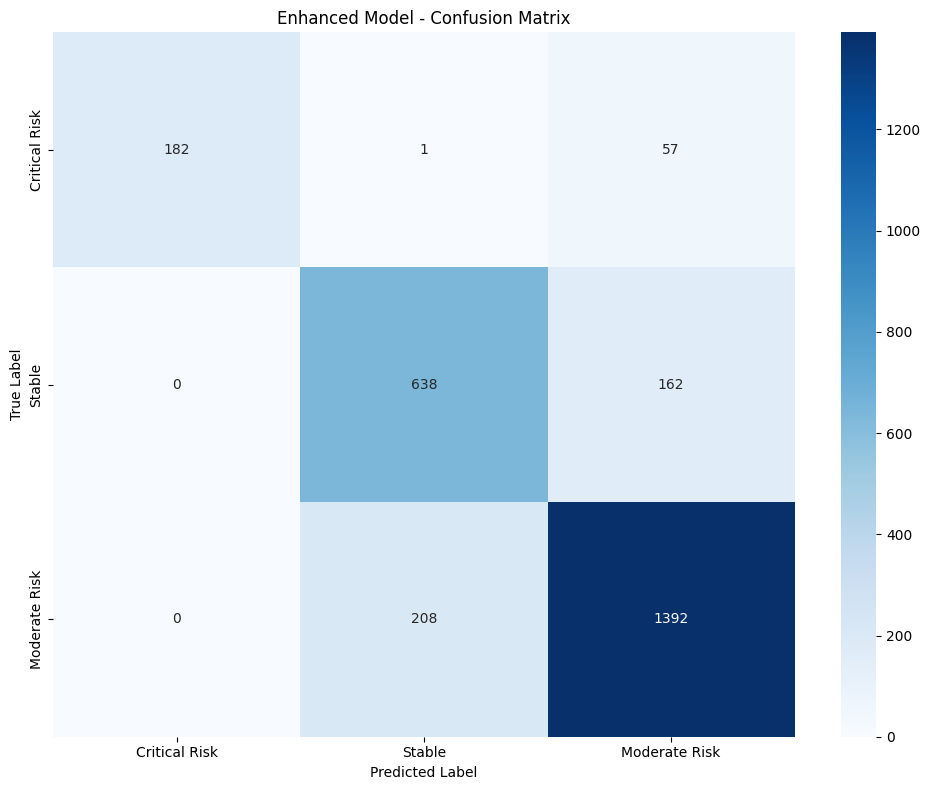

✅ Complete model saved to: D:\Projects\Cardiac Patient Monitoring System\models\ecg_cnn
   - Model: D:\Projects\Cardiac Patient Monitoring System\models\ecg_cnn\enhanced_ecg_cnn_model.pth
   - Scaler: D:\Projects\Cardiac Patient Monitoring System\models\ecg_cnn\scaler.pkl
   - Config: D:\Projects\Cardiac Patient Monitoring System\models\ecg_cnn\preprocessing_config.pkl
   - Info: D:\Projects\Cardiac Patient Monitoring System\models\ecg_cnn\model_info.txt

MODEL SAVING COMPLETED SUCCESSFULLY!


In [15]:
def main_enhanced():
    # Define class names
    class_names = ['Critical Risk', 'Stable', 'Moderate Risk']
    
    # Load data
    df = pd.read_csv(r"D:\Projects\Cardiac Patient Monitoring System\ecg_signals_with_risk_labels.csv")
    
    # Prepare features and labels
    feature_cols = [col for col in df.columns if col.startswith('ecg_')]
    X = df[feature_cols].values
    y = df['risk_level'].map({'Critical Risk': 0, 'Stable': 1, 'Moderate Risk': 2}).values
    
    print(f"Original dataset shape: {X.shape}")
    print(f"Original class distribution: {Counter(y)}")
    
    # Advanced data balancing
    X_balanced, y_balanced = balance_data_advanced(X, y, method='manual_balanced')
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
    )
    
    # Normalize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    # Create datasets
    train_dataset = ECGDataset(X_train_scaled, y_train)
    val_dataset = ECGDataset(X_val_scaled, y_val)
    
    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    
    # Enhanced model
    model = EnhancedECG_CNN(dropout_rate=0.4)
    
    # Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Train model
    trained_model, history = train_advanced_model(
        model, train_loader, val_loader, device, epochs=80
    )
    
    # Enhanced evaluation with threshold tuning
    print("\n" + "="*60)
    print("ENHANCED MODEL EVALUATION WITH THRESHOLD TUNING")
    print("="*60)
    
    model.eval()
    val_preds, val_labels, val_probs = [], [], []
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            probs = F.softmax(output, dim=1)
            pred = output.argmax(dim=1)
            
            val_preds.extend(pred.cpu().numpy())
            val_labels.extend(target.cpu().numpy())
            val_probs.extend(probs.cpu().numpy())
    
    # Convert to numpy arrays
    val_probs = np.array(val_probs)
    val_labels = np.array(val_labels)
    val_preds = np.array(val_preds)
    
    # Original predictions
    print("\nOriginal Predictions:")
    print(classification_report(val_labels, val_preds, target_names=class_names))
    
    # Threshold tuning for Critical Risk
    print("\nThreshold Tuning for Critical Risk:")
    best_threshold = 0.5
    best_f1 = 0
    
    for threshold in np.arange(0.1, 1.0, 0.1):
        # Adjust predictions for Critical Risk
        adjusted_preds = val_preds.copy()
        
        #  Critical Risk أكبر من threshold، اعتبره Critical
        critical_mask = val_probs[:, 0] > threshold
        adjusted_preds[critical_mask] = 0
        
        # Calculate F1 for Critical Risk only
        if np.sum(val_labels == 0) > 0:  # Check if there are actual Critical cases
            critical_f1 = f1_score(val_labels, adjusted_preds, labels=[0], average='micro')
            critical_recall = (adjusted_preds[val_labels == 0] == 0).mean() if np.sum(val_labels == 0) > 0 else 0
            critical_precision = (val_labels[adjusted_preds == 0] == 0).mean() if np.sum(adjusted_preds == 0) > 0 else 0
            
            print(f"Threshold {threshold:.1f}: Precision={critical_precision:.3f}, Recall={critical_recall:.3f}, F1={critical_f1:.3f}")
            
            if critical_f1 > best_f1:
                best_f1 = critical_f1
                best_threshold = threshold
        else:
            print(f"Threshold {threshold:.1f}: No Critical cases in validation set")
    
    print(f"\nBest threshold for Critical Risk: {best_threshold:.1f}")
    
    # Apply best threshold
    final_preds = val_preds.copy()
    critical_mask = val_probs[:, 0] > best_threshold
    final_preds[critical_mask] = 0
    
    print("\nFinal Predictions with Optimized Threshold:")
    print(classification_report(val_labels, final_preds, target_names=class_names))
    
    # Per-class metrics
    print("\nPer-Class Analysis:")
    report_dict = classification_report(val_labels, val_preds, target_names=class_names, output_dict=True)
    for i, class_name in enumerate(class_names):
        precision = report_dict[class_name]['precision']
        recall = report_dict[class_name]['recall']
        f1 = report_dict[class_name]['f1-score']
        print(f"{class_name}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")
    
    # Confusion Matrix
    cm = confusion_matrix(val_labels, val_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Enhanced Model - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('enhanced_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    

    #  save_complete_model
    
    
    balanced_data_info = {
        'original_distribution': Counter(y),
        'balanced_distribution': Counter(y_balanced),
        'balancing_method': 'manual_balanced'
    }
    
    
    model_dir = r"D:\Projects\Cardiac Patient Monitoring System\models\ecg_cnn"
    

    save_complete_model(trained_model, scaler, history, balanced_data_info, model_dir)
    
    print("\n" + "="*60)
    print("MODEL SAVING COMPLETED SUCCESSFULLY!")
    print("="*60)

if __name__ == "__main__":
    main_enhanced()